In [1]:
#import the modules we will need
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from numba import jit
from tqdm.notebook import tqdm


# Functions required


In [71]:


def calcExpK(delta):
    """Function that calculates exponential of hopping matrix"""
    return [[np.cosh(delta),np.sinh(delta)],[np.sinh(delta),np.cosh(delta)]]

def Mphi(phi, expk, nt):
    """
    Function that updates the Fermion matrix
    
    INPUT:
            phi - phi field (array)
            k - hopping parameter (array)
            nt - number of time steps
                        
    OUTPUT:
            M - fermion matrix (update M) 
            
            This uses space index fastest (like Isle)
    """
    n = len(phi)
    nx = int(n/nt)
    if n == M.shape[0]: # this tests if the phi array has the right dimensions
        for t in range(nt-1): # loop over time bloks
            for x in range(nx): # loop over cords and kappa matrix
                M[t*nx+x][t*nx+x] = 1.0 + 0j # diagonal term
                for y in range(nx): # run over the kappa matrix
                    M[(t+1)*nx+x][t*nx+y] = -expk[x][y]*np.exp(1j*phi[t*nx+y]) # off-diagonal
        for x in range(nx): 
            M[(nt-1)*nx+x][(nt-1)*nx+x] = 1.0+0j # diagonal term
            for y in range(nx): # anti-periodic boundary condition
                M[x][(nt-1)*nx+y] = expk[x][y]*np.exp(1j*phi[(nt-1)*nx+y])
        return 0
    else:
        print('# Error! phi and M have inconsistent dimensions!')
        return -1
    
def calcLogDetMM(phi, expk, nt):
    """
    Function that calculates the determinant of Fermion matrices
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            Nt - number of time steps
                        
    OUTPUT:
            detMM - determinant of the matrices
    """
    
    Mphi(phi, expk, nt) # update M with +1 phi
    detMM = np.log(np.linalg.det(M)) # calc detM with +1 phi
    Mphi(-np.array(phi), expk, nt) # update M with -1 phi
    detMM += np.log(np.linalg.det(M)) # calc detM with -1 phi
    return detMM

def calcTrMM(phi, expk, nt, sign):
    """
    Function that calculates the trace of a Fermion matrix
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping term (array)
            nt - number of time steps
            sign - sign of phi (+1 / -1)
                        
    OUTPUT:
            TrMM - trace of the matrix
    """
    TrMM = [] # trace container
    n = len(phi)
    nx = int(n/nt)
    Mphi(phi, expk, nt) # update M
    invM = np.linalg.inv(M)  # only need to invert once!
    for t in range(nt-1): # loop over time blocks
        for x in range(nx): # loop over sites  (space is fastest)
            temp = 0 + 0j
            for y in range(nx):
                temp += invM[t*nx+x][(t+1)*nx+y]*expk[y][x]
            TrMM.append(temp*(-sign*1j*np.exp(1j*phi[t*nx+x])))
    for x in range(nx): # anti-periodic boundry conditions
        temp = 0 + 0j
        for y in range(nx):
            temp += invM[(nt-1)*nx+x][y]*expk[y][x]
        TrMM.append(temp*sign*1j*np.exp(1j*phi[(nt-1)*nx+x]))

    return np.array(TrMM)

def artH(p, phi, expk, nt, U):
    """
    Function that calculates the artificial Hamiltonian of the Hubbard model
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)            
            expk - exponential of hopping array (array)
            Nt - number of timesteps
            U - onsite coupling (reduced quantity = U * delta)
            
            (optional)
            beta = inverse temperature
                        
    OUTPUT:
            H - artificial Hamiltonian
    """
        
    H = .5*(np.array(p)@np.array(p)+np.array(phi)@np.array(phi)/U) 
    
    H -= np.real(calcLogDetMM(phi, expk, nt))
    return H




def gradS(phi,U,Nt):
    """function that calculates gradient"""
    return phi/U - 2*np.real(calcTrMM(phi,expk,Nt,1))

def ribbit(p, phi, expk, nt, U, Nmd, surrogate,training, trajLength = 1.):
    """
    Molecular dynamics integrator (Leap frog algorithm)
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            nt - number of timesteps
            Nmd - number of trajectory pieces
            U - onsite coupling
            surrogate - NN trained gradient
            (optional)
            trajLength - length of trajectory
            training  - if True then save data for training
            
    OUTPUT:
            (p, phi) - after integration
    """    
    # python passes variables via "pass by object"
    # need to define new arrays, otherwise the original arrays will change themselves during this call!
    p = np.array([p[i] for i in range(len(p))])
    phi = np.array([phi[i] for i in range(len(phi))])
    
    train_phi = []
    train_gradient = []
    eps = trajLength/Nmd # integration step
      
    
    phi += 0.5*eps*p # first half step
    if training:
        train_phi.append(phi)
    
    
    # (N - 1) steps of integration
    L = int(np.random.uniform(0, 1)* Nmd)
    for _ in range(L):
        
        if surrogate == None:
            gradient = gradS(phi,U,nt)
            if training:
                train_gradient.append(gradient)
            p -= eps* gradient
        else:
            p -= eps*surrogate.gradient(phi)           #<====== replaced with NN
       
        phi += eps*p
        if training:
            train_phi.append(phi)

    # last half step
    if surrogate == None:
        gradient = gradS(phi,U,nt)
        if training:
            train_gradient.append(gradient)
        p -= eps* gradient
    else:
        p -= eps*surrogate.gradient(phi)                   #<====== replaced with NN
    
    phi += 0.5*eps*p
    
    if training:
        return p, phi, train_phi , train_gradient
    else:
        return p, phi




In [3]:

def HMC(surrogate , training):
    prob = [] # stores probability
    ensemble = []  # store the individual configurations here
    # sample phi from normal distribution with sigma = sqrt(u)
    phi = np.array([np.random.normal(0,usqrt) for i in range(Nt*Nx)])
    
    g = np.zeros((nTrajs,Nt*Nx))
    pp = np.zeros((nTrajs,Nt*Nx))
    training_data = []
    training_gradient = []
  
        
    # loop that generates the ensamble of phis
    for traj in tqdm(range(nTrajs)):
        # sample momentum from normal distribution w/ sigma = 1
        initP = np.array([np.random.normal(0,1) for i in range(Nt*Nx)])
        initPhi = phi #[-Nt*Nx:] # initial Phi
        initH = artH(initP, initPhi, expk, Nt, U*delta) # initial Hamiltonian
        
        # final momentum and phi
        if training:
            finP, finPhi, train_phi, train_gradient = ribbit(initP, initPhi, expk, Nt, U*delta, Nmd,surrogate,training) 
            training_data.append(train_phi)
            training_gradient.append(train_gradient)
        else:
            finP, finPhi = ribbit(initP, initPhi, expk, Nt, U*delta, Nmd,surrogate,training) 
     
        finH = artH(finP, finPhi, expk, Nt, U*delta) # final hamiltonian
        
        pp[traj,:] = finPhi
        if surrogate is None:
            g[traj,:] = gradS(finPhi,U,Nt)           
        else:
            g[traj,:] = surrogate.gradient(finPhi)
        
        # accept/reject step
        if np.random.uniform(0,1) <= np.exp(-(finH-initH)): # accept
            phi = finPhi
            ensemble.append(phi)
            prob.append(1.)
        else: # reject
            ensemble.append(phi)
            prob.append(0.)

    prob = np.array(prob)
    
    if training:
        return ensemble, prob, g, pp, training_data, training_gradient
    else:
        return ensemble, prob, g, pp

In [ ]:
# initialize constants for the functions
U=2. # spin coupling
beta=4. # inverse temperature
Nt=16 # number of time steps
Nx = 2 # number of sites
delta = beta/Nt
usqrt = np.sqrt(delta*U) #reduced U
M = np.identity(Nt*Nx) + 0j # (Nt*Ni) x (Nt*Ni) identity matrix
expk = calcExpK(delta) # calc exp(kappa)
Nmd = 3 # 3-5 for best acceptance >= 70%
nTrajs = 10000 # number of auxiliary fields in the ensemble


In [110]:
#actual,act_prob,g_all,pp_all,trainPhi,trainGrad = HMC(surrogate = None,training = True)
actual,act_prob,g_all,pp_all = HMC(surrogate = None,training = False)
print("actual HMC prob",act_prob.mean())


actual HMC prob 0.79


In [5]:

# Creating Training data from HMC 

md_trainPhi = np.zeros((3*len(trainPhi),Nt*Nx))
md_trainGrad = np.zeros((3*len(trainGrad),Nt*Nx))
count = 0
for i in range(len(trainPhi)):
    for j in range(len(trainPhi[i])):
        md_trainPhi[count,:] = trainPhi[i][j]
        md_trainGrad[count,:] = trainGrad[i][j]
        count += 1
        
print('Total training samples=',count+nTrajs)

training_data = np.zeros((nTrajs+count,Nt*Nx))
gradient = np.zeros((nTrajs+count,Nt*Nx))

training_data[:count,:] = md_trainPhi[:count,:]
training_data[count:,:] = pp_all
gradient[:count,:] = md_trainGrad[:count,:]
gradient[count:,:] = g_all


Total training samples= 30052


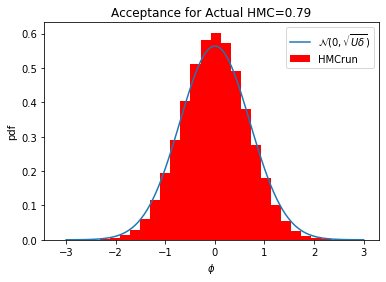

In [115]:
import scipy.stats as stats
x = np.linspace(-3, 3, 100)
plt.title("Acceptance for Actual HMC={}".format(act_prob.mean())) 
plt.hist(np.array(actual).flatten(), density=True, bins=30,label='HMCrun',color='r') 
plt.plot(x, stats.norm.pdf(x, 0, usqrt),label=r'$\mathcal{N}(0,\sqrt{U\delta})$')
plt.ylabel('pdf')
plt.xlabel(r'$\phi$')
plt.legend(loc='best')
#plt.savefig("acceptance_{}.pdf".format(NNg_prob.mean()))


In [116]:
# plt.hist(np.array(pp_all).flatten(),density=True,bins=30,label='all_phi')
# plt.legend()
# plt.savefig("phi_all.pdf")

In [8]:
# f =np.array(pp_all)
# f1 = np.array(md_trainPhi)
# plt.hist(f1.flatten(),density=True,bins=30,label='pp_all')
# plt.legend()
# np.array(actual).shape

(10000, 32)

Stored 'xx' (ndarray)
Stored 'yy' (ndarray)
Stored 'training_gaus' (ndarray)
Stored 'gradient_gaus' (ndarray)
Stored 'data_actual' (ndarray)
Stored 'gradient_actual' (ndarray)
Stored 'training_data' (ndarray)
Stored 'gradient' (ndarray)


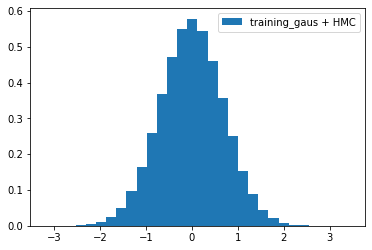

In [47]:
# Generate training data from radnom sampling of normal distribution
num_samples = 10000
training_gaus = np.zeros((num_samples,Nt*Nx))
gradient_gaus = np.zeros((num_samples,Nt*Nx))

data_actual = np.array(actual)
gradient_actual = np.zeros((len(actual),Nt*Nx))

xx = np.zeros((len(actual)+ num_samples,Nt*Nx))
yy= np.zeros((len(actual)+ num_samples,Nt*Nx))

for i in range(num_samples): 
    training_gaus[i,:] = np.random.normal(0,usqrt,Nt*Nx)
    gradient_gaus[i,:] = gradS(training_gaus[i,:],U*delta,Nt)
    gradient_actual[i,:] = gradS(data_actual[i,:],U*delta,Nt)


xx[:num_samples,:] = training_gaus[:num_samples,:]
xx[num_samples:,:] = data_actual[:,:]

yy[:num_samples,:] = gradient_gaus[:num_samples,:]
yy[num_samples:,:] = gradient_actual[:,:]

%store xx
%store yy
%store training_gaus
%store gradient_gaus
%store data_actual
%store gradient_actual
%store training_data
%store gradient
# plt.hist(np.array(training_gaus).flatten(),density=True,bins=30,label='training_gaus')
# plt.legend()

plt.hist(xx.flatten(),density=True,bins=30,label='training_gaus + HMC')
plt.legend()
# plt.savefig("gaus_HMC.pdf")

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
x = xx
y = yy
scaled_data = preprocessing.StandardScaler().fit(x) #scaling the data to zero mean and unit variance
x = preprocessing.scale(x)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

In [57]:
xx.shape

(20000, 32)

In [23]:
# Train the NN to approximate gradient
%reload_ext autoreload
%autoreload 2
from models import exper, build

epoch = 80
batch = 150
model = exper(32, [64] , 32)
#model = build(32,[64],[32])

r = model.fit(x,y,epochs=epoch, batch_size=batch,verbose=2)

#r = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=epoch, batch_size=batch,verbose=2)


loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f'% (accuracy*100), 'Loss: %.2f' % (loss))



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
Total params: 4,192
Trainable params: 4,192
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
134/134 - 1s - loss: 3.1016 - accuracy: 0.2983
Epoch 2/80
134/134 - 0s - loss: 2.7106 - accuracy: 0.4723
Epoch 3/80
134/134 - 0s - loss: 2.5701 - accuracy: 0.5504
Epoch 4/80
134/134 - 0s - loss: 2.5247 - accuracy: 0.5856
Epoch 5/80
134/134 - 0s - loss: 2.4850 - accuracy: 0.6183
Epoch 6/80
134/134 - 0s - loss: 2.4529 - accuracy: 0.6407
Epoch 7/80
134/134 - 0s - loss: 2.4302 - accuracy: 0.6600
Epoch 8/80
134/134 - 0s - loss: 2.4151 - accuracy: 0.6701
Epoch 9/80
134/134 - 0s - loss: 2.4046 - accuracy:

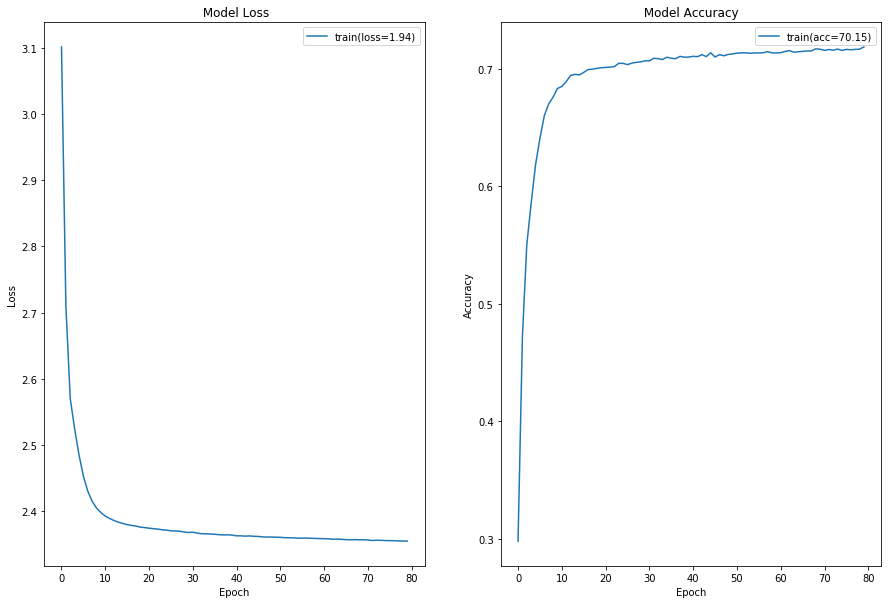

In [46]:

## Loss and Accuracy plots

fig,ax = plt.subplots(1,2,figsize=(15,10),sharex=True)
axx = ax[0]
axx.set_title(" Model Loss")
axx.set_ylabel("Loss")
axx.set_xlabel("Epoch")
axx.plot(r.history['loss'],label='train(loss={})'.format(np.round(loss,2)))
#axx.plot(r.history['val_loss'],label='validation')
axx.legend()

axx = ax[1]
axx.set_title(" Model Accuracy ")
axx.set_ylabel("Accuracy")
axx.set_xlabel("Epoch")
axx.plot(r.history['accuracy'],label='train(acc={})'.format(np.round((accuracy*100),2)))
#axx.plot(r.history['val_accuracy'],label = 'validation')
axx.legend()


plt.savefig("Lossplot.pdf")

In [98]:
# q = model.fit(t,gr,epochs=600,batch_size=34,verbose=2)

# loss, accuracy = model.evaluate(X_train, y_train)
# print('Accuracy: %.2f'% (accuracy*100), 'Loss: %.2f' % (loss))

In [89]:
trial_data = np.zeros((num_samples,Nt*Nx))
for i in range(num_samples): 
    trial_data[i,:] = np.random.normal(0,usqrt,Nt*Nx)
    
trial_scaled = preprocessing.StandardScaler().fit(trial_data)

In [93]:
from surrogate import NeuralGrad

#Using the NN inside HMC to sample points
grad_hat = NeuralGrad(model,trial_scaled)
NNg ,NNg_prob,g_NN,pp_NN = HMC(surrogate = grad_hat, training = False)

print("act_prob=",act_prob.mean())
print("NNg_prob=",NNg_prob.mean())


act_prob= 0.7525
NNg_prob= 0.7335


In [94]:

k = np.where(act_prob == 1.0)
c= np.where(NNg_prob == 1.0)
print(c[0].shape,k[0].shape)


(7335,) (7525,)


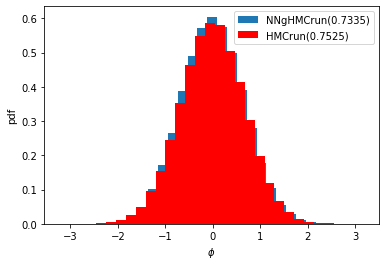

In [95]:
import scipy.stats as stats
flattend = np.array(NNg).flatten()
x = np.linspace(-3, 3, 100)
#plt.title("Acceptance={}".format(NNg_prob.mean()))
plt.hist(flattend, density=True, bins=30,label='NNgHMCrun({})'.format(NNg_prob.mean()))  
plt.hist(np.array(actual).flatten(), density=True, bins=30,label='HMCrun({})'.format(act_prob.mean()),color='r') 
#plt.plot(x, stats.norm.pdf(x, 0, usqrt),label=r'$\mathcal{N}(0,\sqrt{U\delta})$')
plt.ylabel('pdf')
plt.xlabel(r'$\phi$')
plt.legend(loc='best')
#plt.savefig("acceptance_{}.pdf".format(NNg_prob.mean()))

In [96]:
print("NNg mean",flattend.mean())
print("Actual HMC mean",np.array(actual).flatten().mean())
print("Difference in mean between HMc and NNgHMc=",np.abs(np.array(actual).flatten().mean()-flattend.mean()))

NNg mean -0.0004245627922351659
Actual HMC mean -0.005063935716957747
Difference in mean between HMc and NNgHMc= 0.004639372924722581


In [97]:
len(NNg)

10000

In [98]:
#Exact co-relators data 


exactData = open("U2B4.dat").readlines()
exT = []
exBonding = []
exAntiBonding = []
exAA = []
exAB = []
exBA = []
exBB = []
for i in range(len(exactData)):
    split = exactData[i].split()
    exT.append(float(split[0]))   # tau
    exAntiBonding.append(float(split[1]))  # anti-bonding
    exBonding.append(float(split[2]))      # bonding
    exAA.append(float(split[3]))  # cAA
    exAB.append(float(split[4]))  # cAB
    exBA.append(float(split[5]))  # cBA
    exBB.append(float(split[6]))  # cBB

In [111]:
#Calculating co-relators 

def correlators(sample):

    corrUp_b = [ [] for t in range(Nt)] # <===== each correlator has Nt elements
    corrUp_ab = [ [] for t in range(Nt)]
    Cxx = [ [] for t in range(Nt)]
    Cxy = [ [] for t in range(Nt)]
    Cyx = [ [] for t in range(Nt)]
    Cyy = [ [] for t in range(Nt)]

    nTherm = 200

    ### calculate the bonding/anti-bonding correlator
    for i in range(nTherm,nTrajs):
        # arrow up correlator
        phi = sample[i]
        Mphi(phi,expk,Nt)
        invMUp = np.linalg.inv(M)

        # we now construct the correlators
        # bonding correlator is .5*(Cxx+Cxy+Cyx+Cyy)
        # antibonding is .5*(Cxx-Cxy-Cyx+Cyy)
        for t in range(Nt):
            corrUp_b[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]+invMUp[t*Nx+0][0*Nx+1]+
                                   invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
            corrUp_ab[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]-invMUp[t*Nx+0][0*Nx+1]-
                                   invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
            Cxx[t].append(np.real(invMUp[t*Nx+0][0*Nx+0]))
            Cxy[t].append(np.real(invMUp[t*Nx+0][0*Nx+1]))
            Cyx[t].append(np.real(invMUp[t*Nx+1][0*Nx+0]))
            Cyy[t].append(np.real(invMUp[t*Nx+1][0*Nx+1]))

    # here I set up arrays that store the averages
    corrBond = []
    corrAntiBond = []

    # ok, I'm mixing up naming conventions.  Here 'A' = 'x' and 'B' = 'y'
    cAA = []
    cAB = []
    cBA = []
    cBB = []

    # now I calculate the averages for each timeslice
    for t in range(Nt):
        corrBond.append(np.mean(corrUp_b[t]))
        corrAntiBond.append(np.mean(corrUp_ab[t]))
        cAA.append(np.mean(Cxx[t]))
        cAB.append(np.mean(Cxy[t]))
        cBA.append(np.mean(Cyx[t]))
        cBB.append(np.mean(Cyy[t]))

    tau = np.linspace(0,beta-beta/Nt,Nt) # <===== this is the correct distancing for tau
    return corrBond,corrAntiBond,cAA,cAB,cBA,cBB,tau,corrUp_b,corrUp_ab,Cxx,Cxy,Cyx,Cyy

a_corrBond,a_corrAntiBond,a_cAA,a_cAB,a_cBA,a_cBB,a_tau,a_corrUp_b,a_corrUp_ab,a_Cxx,a_Cxy,a_Cyx,a_Cyy = correlators(actual)
corrBond,corrAntiBond,cAA,cAB,cBA,cBB,tau,corrUp_b,corrUp_ab,Cxx,Cxy,Cyx,Cyy = correlators(NNg)



In [112]:
#Binning and Bootstraping
def binAndBoot(corr,nBN,nBS,check):
    # corr is the array of of correlators 
    # nBN is the number or elements to bin
    # nBS is the number of bootstrap samples
    if check == 1:
        # making the correlators in correct form [samples]x[Nt]
        correlators = []
        for i in range(len(corr[0])): # range(samples)
            correlators.append([corr[t][i] for t in range(len(corr))]) #range(Nt)
    else:
        correlators = corr
        
    corrBN = [] #shape [(samples)/nBN x Nt]
    for i in range(int(len(correlators)/nBN)): #range(samples/nBN)
        corrBN.append(np.mean(correlators[i*nBN:(i+1)*nBN],axis=0))
        
    n = len(corrBN)  # length of ensemble (samples/nBN)
    bsMeans = []
    
    # here are my bootstrap indices
    bsSamples = [ np.random.randint(n,size=n) for bs in range(nBS)]  #shape [nBS x (samples/nBN) ]
    for sample in bsSamples: #shape [(samples/nBN) ]
        bsMeans.append(np.mean([corrBN[index] for index in sample],axis=0))   # mean along rows( [(samples/nBN) x Nt]) 
    # bsMeans.append([1 x Nt]), shape [nBS x 16]
    # returns array of shape[1 x Nt]
    return np.std(bsMeans,axis=0) 

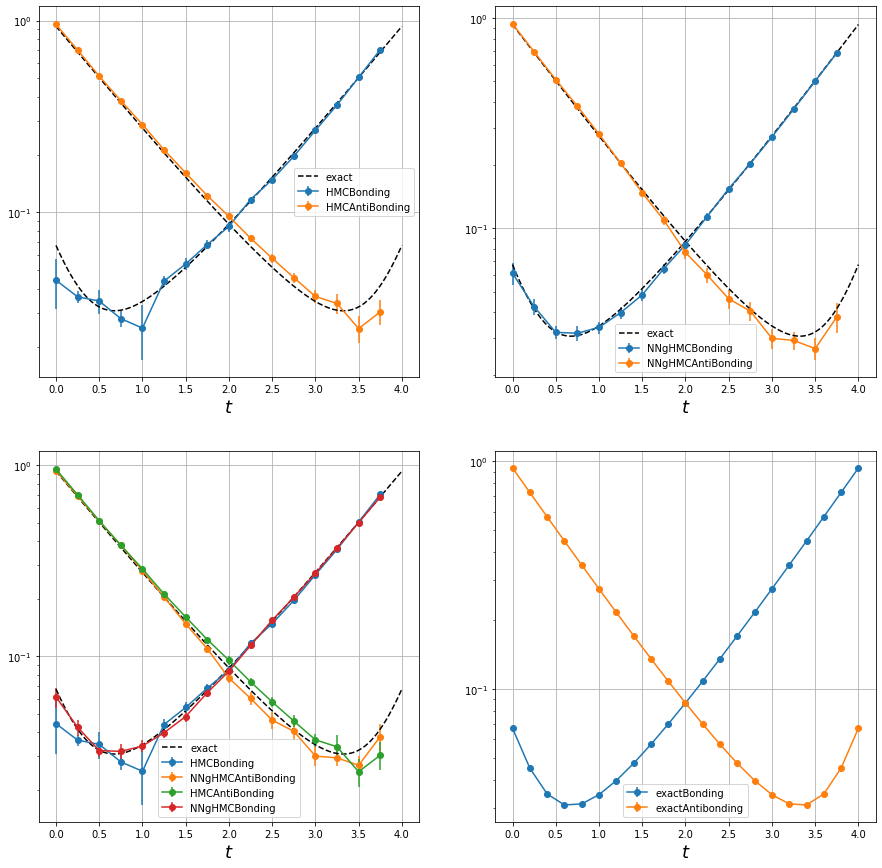

In [113]:
#plotting correlators


fig,ax = plt.subplots(2,2,figsize=(15,15))
axx = ax[0][0]
#axx.plot(a_tau,a_corrBond,'ro',label= r'$HMCBonding$')
axx.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,100,100,1),marker='o',label='HMCBonding')
#axx.plot(a_tau,a_corrAntiBond,'bo', label = '$HMCAntibonding$')
axx.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,100,100,1),marker='o',label='HMCAntiBonding')
axx.plot(exT,exBonding,'k--',label='exact')
axx.plot(exT,exAntiBonding,'k--')
axx.grid()
axx.set_xlabel(r'$t$',fontsize=18)
axx.set_yscale('log')
axx.legend(loc='best')

axx = ax[0][1]
#axx.plot(tau,corrBond,'go',label= r'$NNgBonding$')
axx.errorbar(tau,corrBond,yerr=binAndBoot(corrUp_b,100,400,1),marker='o',label='NNgHMCBonding')
#axx.plot(tau,corrAntiBond,'yo', label = '$NNgAntibonding$')
axx.errorbar(tau,corrAntiBond,yerr=binAndBoot(corrUp_ab,100,400,1),marker='o',label='NNgHMCAntiBonding')
axx.plot(exT,exBonding,'k--',label='exact')
axx.plot(exT,exAntiBonding,'k--')
axx.grid()
axx.set_xlabel(r'$t$',fontsize=18)
axx.set_yscale('log')
axx.legend(loc='best')

axx = ax[1][0]
#axx.plot(tau,corrBond,'go',label= r'$NNgBonding$')
#axx.plot(tau,corrAntiBond,'yo', label = '$NNgAntibonding$')
#axx.plot(a_tau,a_corrBond,'ro',label= r'$HMCBonding$')
#axx.plot(a_tau,a_corrAntiBond,'bo', label = '$HMCAntibonding$')
axx.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,100,400,1),marker='o',label='HMCBonding')
axx.errorbar(tau,corrAntiBond,yerr=binAndBoot(corrUp_ab,100,400,1),marker='o',label='NNgHMCAntiBonding')
axx.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,100,400,1),marker='o',label='HMCAntiBonding')
axx.errorbar(tau,corrBond,yerr=binAndBoot(corrUp_b,100,400,1),marker='o',label='NNgHMCBonding')
axx.plot(exT,exBonding,'k--',label='exact')
axx.plot(exT,exAntiBonding,'k--')
axx.grid()
axx.set_xlabel(r'$t$',fontsize=18)
axx.set_yscale('log')
axx.legend(loc='best')

axx = ax[1][1]
#axx.plot(exT[::50],exBonding[::50],'ro',label='exactBonding')
#axx.plot(exT[::50],exAntiBonding[::50],'bo',label='exactAntibonding')
axx.errorbar(exT[::50],exBonding[::50],yerr=binAndBoot(exBonding[::50],100,400,0),marker='o',label='exactBonding')
axx.errorbar(exT[::50],exAntiBonding[::50],yerr=binAndBoot(exAntiBonding[::50],100,400,0),marker='o',label='exactAntibonding')
# axx.plot(np.array(a_corrBond) - np.array(corrBond),'ro',label= r'$diff_Bonding$')
# axx.plot(np.array(a_corrAntiBond) - np.array(corrAntiBond),'bo', label = '$diff_Antibonding$')
axx.set_xlabel(r'$t$',fontsize=18)
axx.set_yscale('log')
axx.grid()
axx.legend(loc='best')

#plt.savefig("bondingAntiBonding_logerror_{}_10000.pdf".format(NNg_prob.mean()))

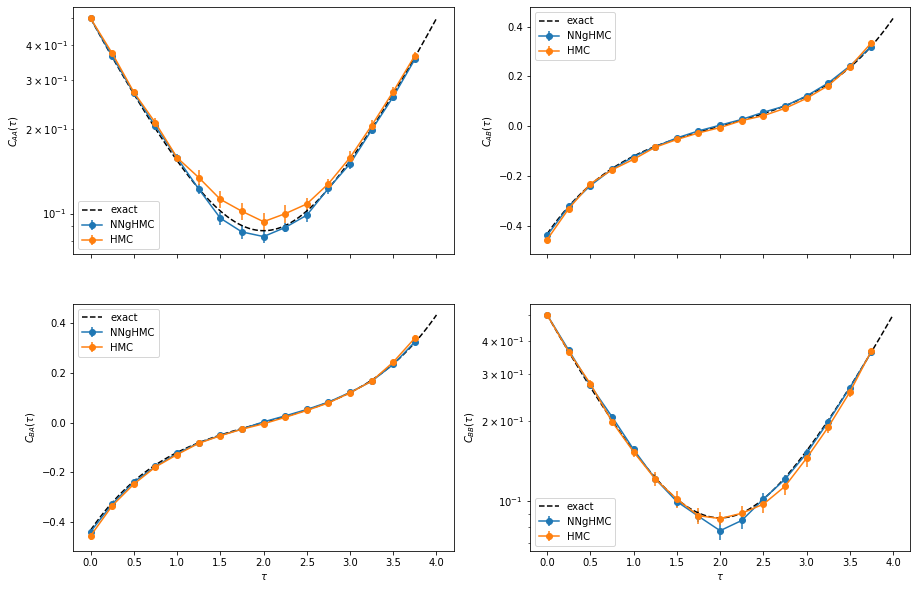

In [114]:
fig,ax = plt.subplots(2,2,figsize=(15,10),sharex=True)

aax = ax[0][0]
aax.plot(exT,exAA,'k--',label='exact')
#aax.plot(tau,cAA,'b.',label='NNgMC')
aax.errorbar(tau,cAA,yerr=binAndBoot(Cxx,100,400,1),marker='o',label='NNgHMC')
#aax.plot(a_tau,a_cAA,'r.',label='HMC')
aax.errorbar(a_tau,a_cAA,yerr=binAndBoot(a_Cxx,100,400,1),marker='o',label='HMC')
aax.set_yscale('log')
aax.legend(loc='best')
aax.set_ylabel(r'$C_{AA}(\tau)$')

aax = ax[0][1]
aax.plot(exT,exAB,'k--',label='exact')
#aax.plot(tau,cAB,'b.',label='NNgHMC')
aax.errorbar(tau,cAB,yerr=binAndBoot(Cxy,100,400,1),marker='o',label='NNgHMC')
#aax.plot(a_tau,a_cAB,'r.',label='HMC')
aax.errorbar(a_tau,a_cAB,yerr=binAndBoot(a_Cxy,100,400,1),marker='o',label='HMC')
#aax.set_yscale('log')
aax.set_ylabel(r'$C_{AB}(\tau)$')
aax.legend(loc='best')

aax = ax[1][0]
aax.plot(exT,exBA,'k--',label='exact')
#aax.plot(tau,cBA,'b.',label='NNgHMC')
aax.errorbar(tau,cBA,yerr=binAndBoot(Cyx,100,400,1),marker='o',label='NNgHMC')
#aax.plot(a_tau,a_cBA,'r.',label='HMC')
aax.errorbar(a_tau,a_cBA,yerr=binAndBoot(a_Cyx,100,400,1),marker='o',label='HMC')
#aax.set_yscale('log')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BA}(\tau)$')
aax.legend(loc='best')

aax = ax[1][1]
aax.plot(exT,exBB,'k--',label='exact')
#aax.plot(tau,cBB,'b.',label='NNgHMC')
aax.errorbar(tau,cBB,yerr=binAndBoot(Cyy,100,400,1),marker='o',label='NNgHMC')
#aax.plot(a_tau,a_cBB,'r.',label='HMC')
aax.errorbar(a_tau,a_cBB,yerr=binAndBoot(a_Cyy,100,400,1),marker='o',label='HMC')
aax.set_yscale('log')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BB}(\tau)$')
aax.legend(loc='best')

#plt.savefig("correlator_logerror_{}_10000.pdf".format(NNg_prob.mean()))